In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import warnings
#warnings.filterwarnings('ignore')
from pathlib import Path
import scipy.stats as stats

# 1. 데이터 로드
# In Colab, __file__ is not defined. Load the file directly using the path.
DATA_PATH = '/content/Google-Playstore.csv'

df = pd.read_csv(DATA_PATH, encoding='ISO-8859-1')
print(f"원본 데이터 크기: {df.shape}")

원본 데이터 크기: (2312944, 24)


In [ ]:
# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 그래프 기본 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2312944 entries, 0 to 2312943
Data columns (total 24 columns):
 #   Column             Dtype  
---  ------             -----  
 0   App Name           object 
 1   App Id             object 
 2   Category           object 
 3   Rating             float64
 4   Rating Count       float64
 5   Installs           object 
 6   Minimum Installs   float64
 7   Maximum Installs   int64  
 8   Free               bool   
 9   Price              float64
 10  Currency           object 
 11  Size               object 
 12  Minimum Android    object 
 13  Developer Id       object 
 14  Developer Website  object 
 15  Developer Email    object 
 16  Released           object 
 17  Last Updated       object 
 18  Content Rating     object 
 19  Privacy Policy     object 
 20  Ad Supported       bool   
 21  In App Purchases   bool   
 22  Editors Choice     bool   
 23  Scraped Time       object 
dtypes: bool(4), float64(4), int64(1), object(15)
memor

In [80]:
df.describe()

,Rating,Rating Count,Minimum Installs,Maximum Installs,Price
count,2.290061e+06,2.290061e+06,2.312837e+06,2.312944e+06,2.312944e+06
mean,2.203152e+00,2.864839e+03,1.834452e+05,3.202017e+05,1.034992e-01
std,2.106223e+00,2.121626e+05,1.513144e+07,2.355495e+07,2.633127e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,5.000000e+01,8.400000e+01,0.000000e+00
50%,2.900000e+00,6.000000e+00,5.000000e+02,6.950000e+02,0.000000e+00
75%,4.300000e+00,4.200000e+01,5.000000e+03,7.354000e+03,0.000000e+00
max,5.000000e+00,1.385576e+08,1.000000e+10,1.205763e+10,4.000000e+02


In [ ]:
df.head()

In [81]:
df.isna().sum()

,0
App Name,5
App Id,0
Category,0
Rating,22883
Rating Count,22883
Installs,107
Minimum Installs,107
Maximum Installs,0
Free,0
Price,0


In [82]:
# 2-1. 불필요한 컬럼 제거

required_cols = ['Price', 'Free', 'App Name', 'Category', 'Maximum Installs', 'Rating', 'days_since_update', 'monetization']
drop_cols = [
    'App Id', 'Developer Id', 'Developer Website', 'Developer Email',
    'Privacy Policy', 'Currency', 'Minimum Android'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [83]:
# (1) Installs 컬럼 전처리: '+'와 ',' 제거 후 numeric

installs_clean = (
    df['Installs']
    .astype(str)
    .str.replace("+", "", regex=False)
    .str.replace(",", "", regex=False)
)
installs_numeric = pd.to_numeric(installs_clean, errors='coerce')

df['Installs'] = installs_numeric

In [84]:
# (2) Size 컬럼 전처리: KB 단위 numeric (조채라 코드 참고)

def _size_to_kb(val: str) -> float:
    """'10M' -> 10240 (KB), '3.4k' -> 3.4 (KB), 'Varies with device' -> np.nan"""
    if pd.isna(val):
        return np.nan
    val = val.replace(',', '')
    if 'Varies with device' in val:
        return np.nan
    if val.endswith('M'):
        return float(val.replace('M', '')) * 1024
    if val.endswith('k'):
        return float(val.replace('k', ''))
    return np.nan

df['Size_KB'] = df['Size'].apply(_size_to_kb)

In [86]:
# (3) 날짜 컬럼 전처리

for col in ['Released', 'Last Updated', 'Scraped Time']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
    else:
        print(f'컬럼 {col} 없음, 변환 생략')


In [85]:


# (4) 평점 결측치 처리 (0.0 → NaN → 평균 대체)

df['Rating'] = df['Rating'].replace(0.0, np.nan)
mean_rating = df['Rating'].mean()
df['Rating'] = df['Rating'].fillna(mean_rating)


In [89]:
#  EDA 시각화 (각 분석별로 시각화)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

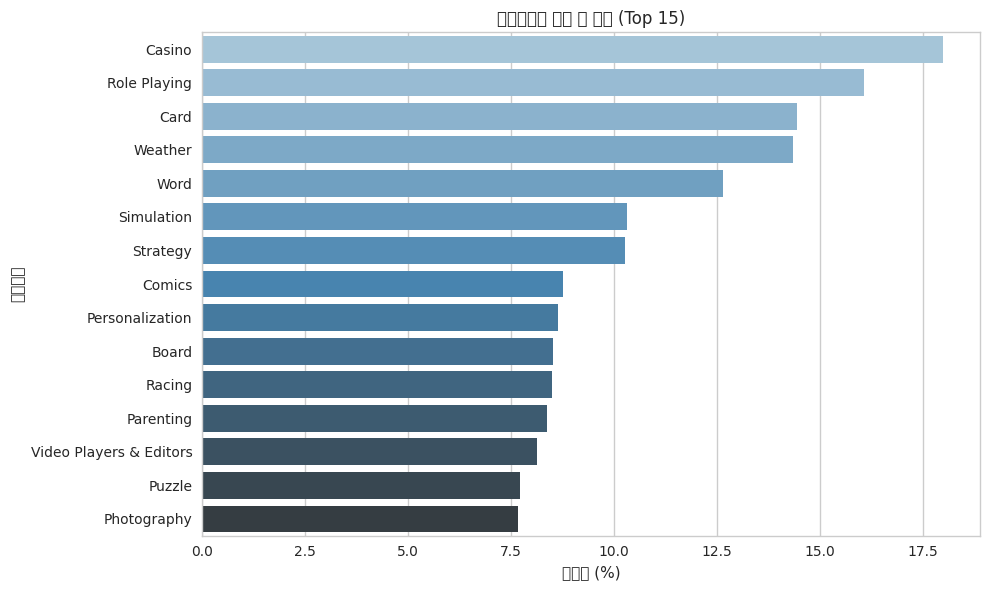

In [90]:
# (1) 카테고리별 성공률 상위 15개
try:
    if 'Category' in df.columns and 'is_success' in df.columns:
        cat_success = pd.crosstab(df['Category'], df['is_success'], normalize='index') * 100
        cat_success = cat_success.sort_values(1, ascending=False).head(15)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=cat_success[1], y=cat_success.index, palette='Blues_d')
        plt.title('카테고리별 성공 앱 비율 (Top 15)')
        plt.xlabel('성공률 (%)')
        plt.ylabel('카테고리')
        plt.tight_layout()
        plt.show()
    else:
        print('카테고리별 성공률 시각화에 필요한 컬럼이 없습니다.')
except Exception as e:
    print(f'카테고리별 성공률 시각화 오류: {e}')


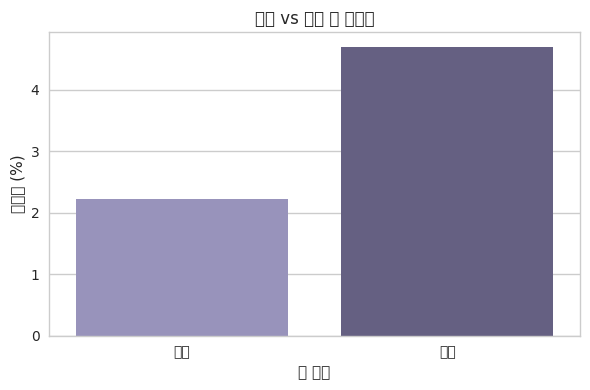

In [91]:
# (2) 무료 vs 유료 성공률
free_success = pd.crosstab(df['Free'], df['is_success'], normalize='index') * 100
plt.figure(figsize=(6,4))
sns.barplot(x=free_success.index.map({True:'무료', False:'유료'}), y=free_success[1], palette='Purples_d')
plt.title('무료 vs 유료 앱 성공률')
plt.ylabel('성공률 (%)')
plt.xlabel('앱 유형')
plt.tight_layout()
plt.show()

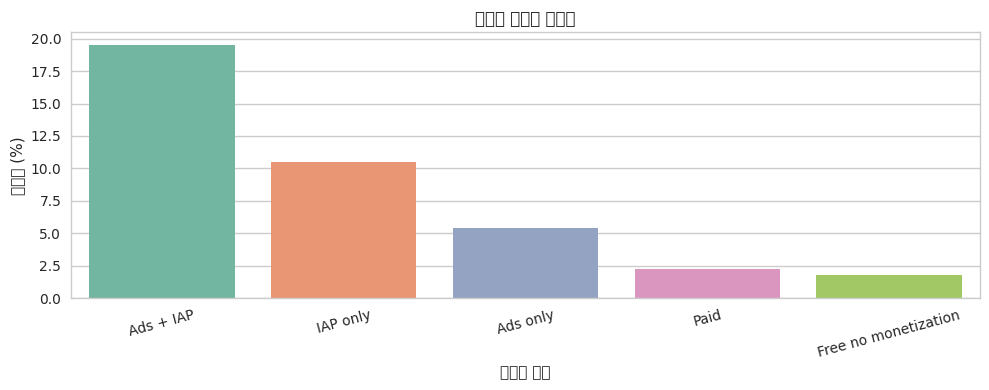

In [92]:
# (3) Monetization 방식 성공률
mon_success = pd.crosstab(df['monetization'], df['is_success'], normalize='index') * 100
mon_success = mon_success.sort_values(1, ascending=False)
plt.figure(figsize=(10,4))
sns.barplot(x=mon_success.index, y=mon_success[1], palette='Set2')
plt.title('수익화 방식별 성공률')
plt.ylabel('성공률 (%)')
plt.xlabel('수익화 방식')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

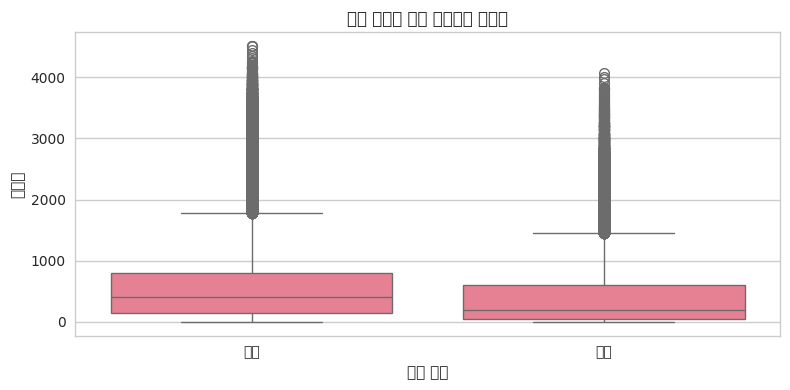

In [93]:
# (4) 업데이트 주기 (성공/실패)
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='is_success', y='days_since_update')
plt.xticks([0,1], ['실패', '성공'])
plt.title('성공 여부에 따른 업데이트 경과일')
plt.ylabel('경과일')
plt.xlabel('성공 여부')
plt.tight_layout()
plt.show()


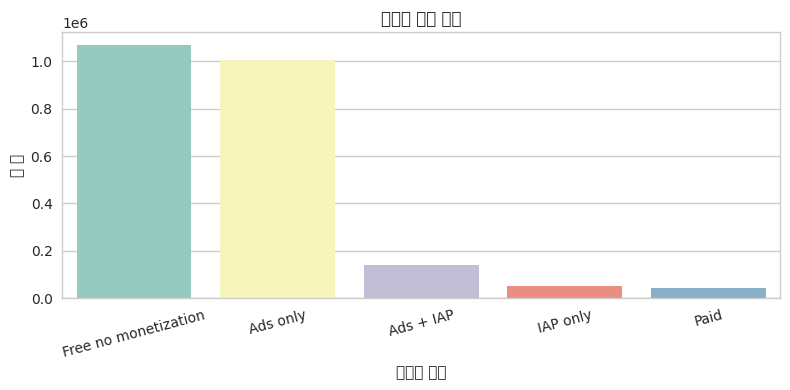

In [94]:
# (5) 수익화 유형 분포
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='monetization', order=df['monetization'].value_counts().index, palette='Set3')
plt.title('수익화 유형 분포')
plt.xlabel('수익화 유형')
plt.ylabel('앱 수')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

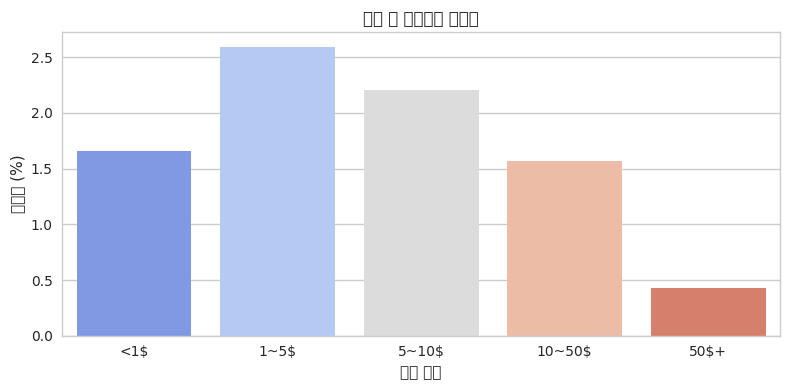

In [95]:
# (6) 유료 앱 가격대별 성공률
paid = df[df['Free'] == False].copy()
price_bins = [0, 1, 5, 10, 50, np.inf]
price_labels = ['<1$', '1~5$', '5~10$', '10~50$', '50$+']
paid['price_bucket'] = pd.cut(paid['Price'], bins=price_bins, labels=price_labels, right=False)
price_success = pd.crosstab(paid['price_bucket'], paid['is_success'], normalize='index') * 100
plt.figure(figsize=(8,4))
price_success = price_success.sort_index()
sns.barplot(x=price_success.index, y=price_success[1], palette='coolwarm')
plt.title('유료 앱 가격대별 성공률')
plt.xlabel('가격 구간')
plt.ylabel('성공률 (%)')
plt.tight_layout()
plt.show()


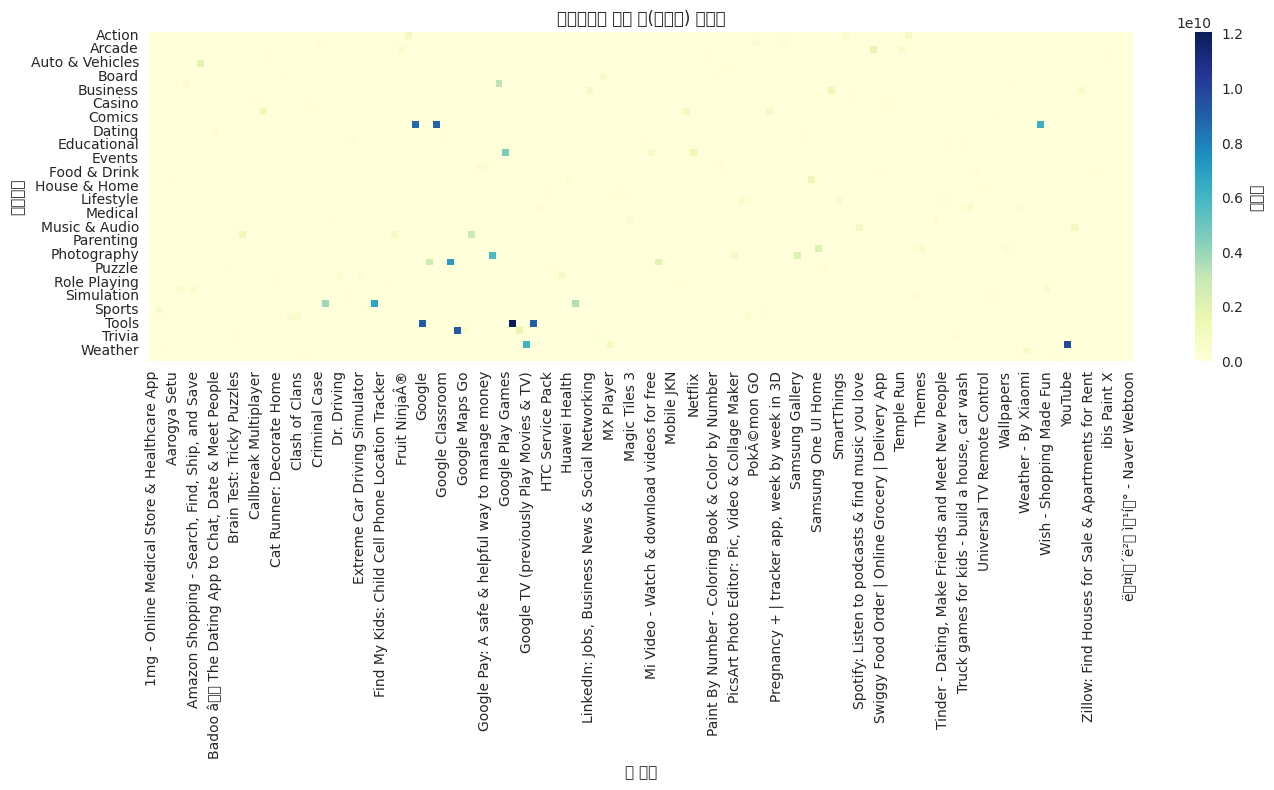

In [98]:
# (7) 카테고리별 인기 앱 heatmap (설치수 기준)
if all(col in popular_per_cat.columns for col in ['Category', 'App Name', 'Maximum Installs']) and not popular_per_cat.empty:
    try:
        popular_pivot = popular_per_cat.pivot_table(index='Category', columns='App Name', values='Maximum Installs', fill_value=0)
        if not popular_pivot.empty:
            plt.figure(figsize=(14,8))
            sns.heatmap(popular_pivot, annot=False, cmap='YlGnBu', cbar_kws={'label': '설치수'})
            plt.title('카테고리별 인기 앱(설치수) 히트맵')
            plt.xlabel('앱 이름')
            plt.ylabel('카테고리')
            plt.tight_layout()
            plt.show()
        else:
            print('카테고리별 인기 앱 피벗 데이터가 없습니다.')
    except Exception as e:
        print(f'카테고리별 인기 앱 히트맵 오류: {e}')
else:
    print('카테고리별 인기 앱 데이터가 없습니다.')

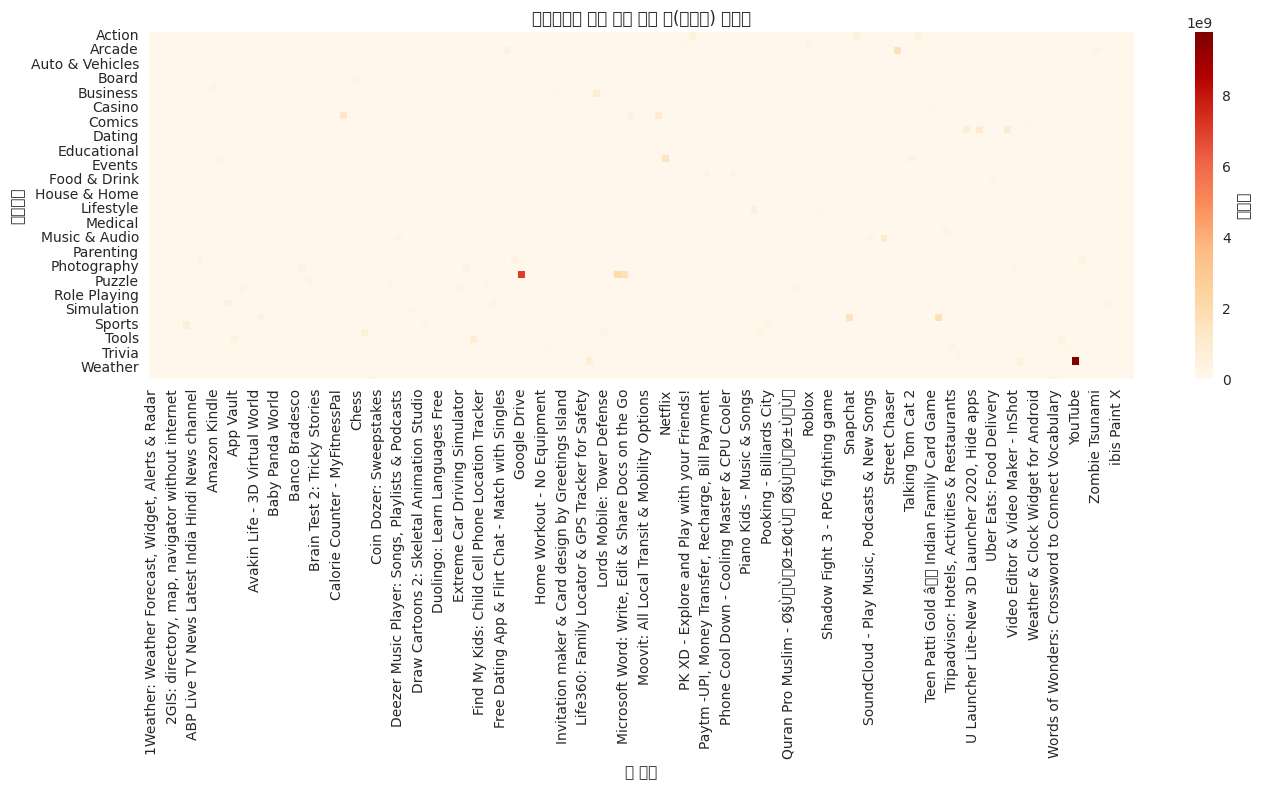

In [99]:
# (8) 성공 확률 높은 후보앱 heatmap (설치수+평점)
if all(col in success_candidates.columns for col in ['Category', 'App Name', 'Maximum Installs']) and not success_candidates.empty:
    try:
        success_pivot = success_candidates.pivot_table(index='Category', columns='App Name', values='Maximum Installs', fill_value=0)
        if not success_pivot.empty:
            plt.figure(figsize=(14,8))
            sns.heatmap(success_pivot, annot=False, cmap='OrRd', cbar_kws={'label': '설치수'})
            plt.title('카테고리별 성공 확률 높은 앱(설치수) 히트맵')
            plt.xlabel('앱 이름')
            plt.ylabel('카테고리')
            plt.tight_layout()
            plt.show()
        else:
            print('성공 확률 높은 후보앱 피벗 데이터가 없습니다.')
    except Exception as e:
        print(f'성공 확률 높은 후보앱 히트맵 오류: {e}')
else:
    print('성공 확률 높은 후보앱 데이터가 없습니다.')

In [ ]:
# 8. 성공 확률이 높은 앱 추출 로직
#    - Rating 상위 25%
#    - Maximum Installs 상위 10%
#    - 업데이트 경과일 하위 25% (더 자주 업데이트)
#    - Monetization 가능한 앱 (Paid, Ads, IAP 등)
#--------------------------------------------------
# 성공 확률 높은 후보앱 추출
rating_thr = df['Rating'].quantile(0.75)
install_thr = df['Maximum Installs'].quantile(0.90)
update_thr = df['days_since_update'].quantile(0.25)
monetizable = df['monetization'] != 'Free no monetization'
success_candidates = (
    df[
        (df['Rating'] >= rating_thr)
        & (df['Maximum Installs'] >= install_thr)
        & (df['days_since_update'] <= update_thr)
        & monetizable
    ].copy()
    .sort_values(['Category', 'Maximum Installs', 'Rating'], ascending=[True, False, False])
    .groupby('Category')
    .head(3)
    .loc[:, ['Category', 'App Name', 'Maximum Installs', 'Rating', 'days_since_update', 'monetization']]
    .reset_index(drop=True)
)




In [99]:
# 6. 결과 저장
#--------------------------------------------------
OUTPUT_PATH = Path(__file__).resolve().parent / 'playstore_processed.csv'
df.to_csv(OUTPUT_PATH, index=False)
print(f"전처리 및 라벨링 완료 데이터 저장: {OUTPUT_PATH}")


In [112]:
# 3. 상관계수
corr = raw[['Released', 'update_gap']].dropna()
corr_val = corr['Released'].map(pd.Timestamp.toordinal).corr(corr['update_gap'])
print(f'출시일-업데이트 경과일 상관계수: {corr_val:.3f}')

출시일-업데이트 경과일 상관계수: -0.535


In [ ]:
# (추가) 출시일-업데이트 주기 관계 분석
#--------------------------------------------------
# drop에서 제외된 Released, Last Updated 컬럼을 다시 불러옴
raw = pd.read_csv(DATA_PATH, encoding='ISO-8859-1')
raw['Released'] = pd.to_datetime(raw['Released'], errors='coerce')
raw['Last Updated'] = pd.to_datetime(raw['Last Updated'], errors='coerce')
raw['update_gap'] = (raw['Scraped Time'].astype(str).apply(pd.to_datetime, errors='coerce') - raw['Last Updated']).dt.days
raw['release_year'] = raw['Released'].dt.year

In [ ]:
# 1. 출시일(연도) vs 업데이트 주기(경과일) 산점도
plt.figure(figsize=(10,5))
plt.scatter(raw['Released'], raw['update_gap'], alpha=0.1)
plt.title('출시일 vs 업데이트 경과일 산점도')
plt.xlabel('출시일')
plt.ylabel('업데이트 경과일')
plt.tight_layout()
plt.show()

In [ ]:
# 2. 출시연도별 평균 업데이트 주기
yearly = raw.groupby('release_year')['update_gap'].mean().dropna()
plt.figure(figsize=(10,4))
plt.plot(yearly.index, yearly.values, marker='o')
plt.title('출시연도별 평균 업데이트 경과일')
plt.xlabel('출시연도')
plt.ylabel('평균 업데이트 경과일')
plt.tight_layout()
plt.show()

In [ ]:
# 유료/무료, 인앱 결제 유무가 설치수/평점에 미치는 영향 분석 및 시각화
if all(col in df.columns for col in ['Free', 'In App Purchases', 'Maximum Installs', 'Rating']):
    # 1. 유료/무료 vs 설치 수
    plt.figure(figsize=(7,5))
    sns.boxplot(x=df['Free'].map({True:'무료', False:'유료'}), y=df['Maximum Installs'], showfliers=False)
    plt.yscale('log')
    plt.title('유료/무료에 따른 설치 수 분포')
    plt.xlabel('앱 유형')
    plt.ylabel('설치 수 (log scale)')
    plt.tight_layout()
    plt.show()


In [ ]:
    # 2. 유료/무료 vs 평점
    plt.figure(figsize=(7,5))
    sns.violinplot(x=df['Free'].map({True:'무료', False:'유료'}), y=df['Rating'])
    plt.title('유료/무료에 따른 평점 분포')
    plt.xlabel('앱 유형')
    plt.ylabel('평점')
    plt.tight_layout()
    plt.show()


In [ ]:
# 3. 인앱 결제 유무 vs 설치 수
    plt.figure(figsize=(7,5))
    sns.boxplot(x=df['In App Purchases'].map({True:'인앱 결제 있음', False:'인앱 결제 없음'}), y=df['Maximum Installs'], showfliers=False)
    plt.yscale('log')
    plt.title('인앱 결제 유무에 따른 설치 수 분포')
    plt.xlabel('인앱 결제')
    plt.ylabel('설치 수 (log scale)')
    plt.tight_layout()
    plt.show()

In [ ]:
# 4. 인앱 결제 유무 vs 평점
    plt.figure(figsize=(7,5))
    sns.violinplot(x=df['In App Purchases'].map({True:'인앱 결제 있음', False:'인앱 결제 없음'}), y=df['Rating'])
    plt.title('인앱 결제 유무에 따른 평점 분포')
    plt.xlabel('인앱 결제')
    plt.ylabel('평점')
    plt.tight_layout()
    plt.show()
else:
    print('유료/무료, 인앱 결제, 설치 수, 평점 컬럼이 모두 필요합니다.')

In [ ]:
# 'Editors Choice' 앱 특징 분석 및 일반 앱과의 비교 시각화
if 'Editors Choice' in df.columns:
    df['Editors Choice Label'] = df['Editors Choice'].map({True: "Editor's Choice", False: '일반 앱'})
    compare_cols = [
        ('Rating', '평점'),
        ('Maximum Installs', '설치 수'),
        ('Size_KB', '앱 크기(KB)'),
        ('days_since_update', '업데이트 경과일')
    ]
    for col, label in compare_cols:
        if col in df.columns:
            plt.figure(figsize=(7,5))
            sns.boxplot(x='Editors Choice Label', y=col, data=df, showfliers=False)
            if col in ['Maximum Installs', 'Size_KB', 'days_since_update']:
                plt.yscale('log')
            plt.title(f"Editor's Choice vs 일반 앱: {label} 분포")
            plt.xlabel('앱 유형')
            plt.ylabel(label)
            plt.tight_layout()
            plt.show()
        else:
            print(f'{col} 컬럼이 없어 시각화 생략')

In [ ]:
 # 카테고리 분포
    if 'Category' in df.columns:
        plt.figure(figsize=(10,6))
        sns.countplot(data=df, y='Category', hue='Editors Choice Label', order=df['Category'].value_counts().index)
        plt.title("Editor's Choice vs 일반 앱: 카테고리 분포")
        plt.xlabel('앱 수')
        plt.ylabel('카테고리')
        plt.legend(title='앱 유형')
        plt.tight_layout()
        plt.show()
else:
    print("'Editors Choice' 컬럼이 없습니다.")